


# Numerical accuracy of uvcontsub2021

This notebook simulates MeasurementSets with known continuum shapes (for example, as polynomials of different order with known coefficients). It has functions to produce MSs including point sources, spectral lines, added noise, and polynomial continuum functions. These MSs can be used to test the numerical accuracy of the task uvcontsub2021, illustrate its usage and experiment with it under different simulated conditions. 




# Preparations. Installs and imports.


## Install required packages

In [ ]:
if 'google.colab' in str(get_ipython()):
  import sys
  print(f'Running in colab, Python version {sys.version}')
  import os
  print("installing pre-requisite packages...")
  os.system("apt-get install libgfortran3")
  
  # Try to use wheels from CAS-13631 or CAS-13686 => nope (CPython 3.6 (cp36) compatibility issues)
  # !pip --verbose install https://open-bamboo.nrao.edu/browse/CASA-C6B502-1/artifact/shared/Tool-wheel/casatools-6.4.3.8a13631.dev1-cp36-cp36m-manylinux2010_x86_64.whl
  # https://open-bamboo.nrao.edu/browse/CASA-C6B502-1/artifact/shared/Task-wheel/casatasks-6.4.3.8a13631.dev1-py3-none-any.whl
  print("installing casatasks...")
  os.system("pip install --extra-index-url --index-url=https://go.nrao.edu/pypi casatasks")

  print("installing casadata...")
  os.system("pip install --extra-index-url --index-url=https://go.nrao.edu/pypi casadata")


Running in colab, Python version 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
installing pre-requisite packages...
installing casatasks...
installing casadata...


## Import required CASA tasks and tools, and other packages

In [ ]:
from casatools import componentlist, ctsys, measures, simulator, table
from casatasks import flagdata, listobs
from casatasks.private import simutil
import numpy as np
import glob
import os, shutil

cl = componentlist()
sm = simulator()

# Definition of simulation building blocks
This section defines function to:
* Create a MeasurementSet with basic structure
* Plot visibilities
* Populate and edit the visibilities of an MS (add sources, continuum, noise, etc.)

Uses functions from https://github.com/urvashirau/Simulation-in-CASA/blob/master/Basic_Simulation_Demo/Simulation_Script_Demo.ipynb, adapted to this set of simulations for uvcontsub.

## Make MS structure

In [ ]:
def make_ms_frame(msname, ant_config, spw_params=None):
  """ 
  Construct an empty MeasurementSet that has the desired observation setup. 

  Args:
      msname: MS to create
      ant_config: a telescope configuration from casadata (alma/simmos) (for 
                  example  alma/simmos/aca.cycle8.cfg)
      swp_params: parameters such as SPW name, number of channels, frequency
  """ 
  ## Open the simulator
  sm.open(ms=msname);

  ## Read/create an antenna configuration. 
  ## Canned antenna config text files are located here: <casadata>/alma/simmos/*cfg
  antennalist = os.path.join(ctsys.resolve("alma/simmos"), ant_config)
  verbose = False
  if verbose:
    print(f'Using antenna list file: {antennalist}')
    
  ## Fictitious telescopes can be simulated by specifying x, y, z, d, an, telname, antpos.
  ##     x,y,z are locations in meters in ITRF (Earth centered) coordinates. 
  ##     d, an are lists of antenna diameter and name.
  ##     telname and obspos are the name and coordinates of the observatory. 
  mysu = simutil.simutil()
  (x,y,z,d,an,an2,telname, obspos) = mysu.readantenna(antennalist)

  ## Set the antenna configuration
  metool = measures()
  sm.setconfig(telescopename=telname,
               x=x,
               y=y,
               z=z,
               dishdiameter=d,
               mount=['alt-az'], 
               antname=an,
               coordsystem='local',
               referencelocation=metool.observatory(telname));

  ## Set the polarization mode (this goes to the FEED subtable)
  sm.setfeed(mode='perfect X Y', pol=['']);    # X Y / R L

  ## Set the spectral window and polarization (one data-description-id). 
  ## Call multiple times with different names for multiple SPWs or pol setups.
  sm.setspwindow(spwname=spw_params['name'],
                 freq=spw_params['freq'],
                 deltafreq='0.1GHz',
                 freqresolution='0.2GHz',
                 nchannels=spw_params['nchan'],
                 stokes='XX YY');

  ## Setup source/field information (i.e. where the observation phase center is)
  ## Call multiple times for different pointings or source locations.
  source_name = 'simulated_source'
  sm.setfield(sourcename=source_name,
              sourcedirection=metool.direction(rf='J2000',
                                               v0='19h59m28.5s',v1='+40d44m01.5s'));

  ## Set shadow/elevation limits (if you care). These set flags.
  sm.setlimits(shadowlimit=0.01, elevationlimit='1deg');

  ## Leave autocorrelations out of the MS.
  sm.setauto(autocorrwt=0.0);  

  ## Set the integration time, and the convention to use for timerange specification
  ## Note : It is convenient to pick the hourangle mode as all times specified in sm.observe()
  ##        will be relative to when the source transits.
  sm.settimes(integrationtime='2s',
              usehourangle=True,
              referencetime=metool.epoch('UTC','2021/10/14/00:01:02'));

  ## Construct MS metadata and UVW values for one scan and ddid 
  ## Call multiple times for multiple scans.
  ## Call this with different sourcenames (fields) and spw/pol settings as defined above.
  ## Timesteps will be defined in intervals of 'integrationtime', between starttime and stoptime.
  sm.observe(sourcename=source_name,
             spwname=spw_params['name'],
             starttime='0', 
             stoptime='+8s');

  ## Close the simulator
  sm.close()
    
  ## Unflag everything (unless you care about elevation/shadow flags)
  flagdata(vis=msname, mode='unflag', flagbackup=False)

## Plotting of visibilities and uv coverage

In [ ]:
def plot_ms_data(msname='sim_data.ms', myplot='uv', plot_complex='abs'):
    """
    Options : myplot='uv'
              myplot='data_spectrum'
  Args:
      plot_complex: 'abs', 'real', or 'imag'
    """
    from casatools import table
    import pylab as pl
    import numpy as np

    tb = table()
    from matplotlib.collections import LineCollection
    tb.open(msname)

    # UV coverage plot
    if myplot=='uv':
        pl.figure(figsize=(4,4))
        pl.clf()
        uvw = tb.getcol('UVW')
        pl.plot( uvw[0], uvw[1], '.')
        pl.plot( -uvw[0], -uvw[1], '.')
        pl.title('UV Coverage')
    
    # Spectrum of chosen column. Make a linecollection out of each row in the MS.
    if myplot=='data_spectrum' or myplot=='corr_spectrum' or myplot=='resdata_spectrum'  or myplot=='rescorr_spectrum' or myplot=='model_spectrum':
        dats=None
        if myplot=='data_spectrum':
            dats = tb.getcol('DATA')
        if myplot=='corr_spectrum':
            dats = tb.getcol('CORRECTED_DATA')
        if myplot=='resdata_spectrum':
            dats = tb.getcol('DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='rescorr_spectrum':
            dats = tb.getcol('CORRECTED_DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='model_spectrum':
            dats = tb.getcol('MODEL_DATA')
            
        xs = np.zeros((dats.shape[2],dats.shape[1]),'int')
        for chan in range(0,dats.shape[1]):
            xs[:,chan] = chan
    
        npl = dats.shape[0]
        fig, ax = pl.subplots(1,npl,figsize=(10,4))
        
        if plot_complex == 'abs':
            complex_func = np.abs
        elif plot_complex == 'real':
            complex_func = np.real
        elif plot_complex == 'imag':
            complex_func = np.imag
        else:
            raise ValueError(f'Invalid plot_complex: {plot_complex}')
        
        for pol in range(0,dats.shape[0]):
            x = xs
            y = complex_func(dats[pol,:,:]).T 
            data = np.stack(( x,y ), axis=2)
            ax[pol].add_collection(LineCollection(data))
            ax[pol].set_title(myplot + ' \n pol '+str(pol))
            ax[pol].set_xlim(x.min(), x.max())
            ax[pol].set_ylim(y.min(), y.max())
        pl.show()

## Update visibilities
Define functions to manipulate visibilities. These functions can be used to introduce noise, point sources, spectral lines, and polynomial-shaped continuum, into MSs in an additive way. The main functions defined here that will be used in the following sections are:

* add_ms_gaussian_noise: use the simulator 'simplenoise' mode to add random Gaussian noise
* add_point_source_component: adds a point source that can be flat or spectral index
* add_spectral_line: adds a simulated line (with Gaussian shape) to the visibilities (real part)
* add_polynomial_cont: adds continuum defined as polynomial of a given order and known coefficients. The polynomials are added to both the real and imaginary parts of the visibilities, for verification testing.



In [ ]:
def add_ms_gaussian_noise(ms_name, noise_level_sigma='0.1Jy'):
   """
   Adds Gaussian random noise using simulator / corrupt
  
   Args:
       ms_name: MS to modify
       noise_level_sigma: noise sigma as used in the simulator corrupt function
   """
   try:
      sm.openfromms(ms_name)
      sm.setseed(4321)
      sm.setnoise(mode='simplenoise', simplenoise=noise_level_sigma)
      sm.corrupt()
   finally:
      sm.close()

In [ ]:
def make_point_source_comp_list(cl_name, freq, flux, spectrumtype, index):
   """
   Makes a component list file with a point source
  
   Args:
       cl_name: name of the component list file to create
       freq: freq quantity (with units) as used in the component list tool 
       flux: flux, units are assumed in Jy
       spectrumtype: as used in component list tool: constant/spectral index
       index: spectral index
   """
   try:
     cl.addcomponent(dir='J2000 19h59m28.5s +40d44m01.5s', 
                     flux=flux,
                     fluxunit='Jy', 
                     freq=freq,
                     shape='point',   # shape='gaussian',
                     # majoraxis="5.0arcmin", minoraxis='2.0arcmin',
                     # polarization='linear', / 'Stokes'
                     # spectrumtype:'spectral index' / 'constant'
                     spectrumtype=spectrumtype,
                     index=index,
                     label='sim_point_source')
     cl.rename(filename=cl_name)
   finally:
     cl.close()

In [ ]:
def sim_from_comp_list(ms_name, cl_name):
   """
   Updates the MS visibilities using simulator.predict to add
   components from the components list

   Args:
       ms_name: MS to modify
       cl_name: name of components list file to simulate
   """
   try:
       sm.openfromms(ms_name)
       sm.predict(complist=cl_name, incremental=False)
   finally:
      sm.close()

In [ ]:
def add_point_source_component(ms_name, freq=None, flux=5.0, 
                               spectrumtype='constant', index=-1):
   """
   Adds a point source to the MS
 
   Args:
       ms_name: MS to modify
       freq: 
       spectrumtype:
       flux: In Jy, as used in componentlist.addcomponent
   """
   cl_name = 'sim_point_source.cl'
   make_point_source_comp_list(cl_name=cl_name, freq=freq, flux=flux,  
                               spectrumtype=spectrumtype, index=index)
   sim_from_comp_list(ms_name, cl_name)
   shutil.rmtree(cl_name)

In [ ]:
def add_spectral_line(ms_name, chan_range=[60,86], amp_factor=None):
   """Adds a spectral line as a Gaussian function in the range 
   of channels given
  
   Args:
       ms_name: MS to modify
       chan_range: list with indices of the first and last channel
       amp_factor: factor to multiply the peak height / flux density
   """
   try:
      tbtool = table()
      tbtool.open(ms_name, nomodify=False)
      data = tbtool.getcol('DATA')

      def gauss(x, mu, sigma):
         return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))
      x = np.linspace(-3, 3, chan_range[1]-chan_range[0])
      bell_line = gauss(x, 0, 0.58)

      ## Add same gaussian to real and imag part
      # data has indices pol:chan:time
      if not amp_factor:
         amp_factor = 1.0/np.max(bell_line)
      data[:,chan_range[0]:chan_range[1],:] +=\
         amp_factor * (1+0j) * bell_line.reshape((1, len(bell_line),1))

      tbtool.putcol('DATA', data)
   finally:
      tbtool.done()

In [ ]:
def add_polynomial_cont(ms_name, pol_coeff, nchan, amp_factor=1.0):
   """
   Update MS visibilities adding a polynomial evaluated for all channels.

   Args:
       ms_name: MS to modify
       pol_coeff: polynomial coefficients, evaluated [0.5, 0.25] => 0.5x + 0.25
       nchan: number of channels in the SPW (x axis to eval polynomial)
   """
   try:
      tbtool = table()
      tbtool.open(ms_name, nomodify=False)
      data = tbtool.getcol('DATA')

      x = np.linspace(0, 1, nchan)
      polynomial = np.polyval(pol_coeff, x)
      # Add same polynomial to real and imag part
      data += amp_factor * (1+1j) * polynomial.reshape((1, len(polynomial),1))

      tbtool.putcol('DATA', data)
   finally:
      tbtool.done()

# Produce simulated MeasurementSets - for task verfication test

Produce simulated MeasurementSets that are used in the uvcontsub2021 task verification test.
These simulations produce MSs that include:
* a constant spectrum source, with flux density 0.5Jy by default
* a line of with approximately 20% of the SPW, with peak flux density 1Jy
* various polynomials of order 0, 1, 2, etc., 
* noise with sigma 0.1Jy. 

The polynomials are added to the real an imaginary parts of the visibilities for all channels. The accuracy in fitting these polynomials is then tested in the verification test of uvcontsub2021. More details and discussion can be found in [CAS-13632](https://open-jira.nrao.edu/browse/CAS-13632).

The list of verification tests of uvcontsub2021 is detailed here, including the tests of numerical accuracy that use the MSs simulated in this notebook: https://open-confluence.nrao.edu/display/CASA/uvcontsub2021
For further details, the tests implemented in the uvcontsub can be seen here: https://open-bitbucket.nrao.edu/projects/CASA/repos/casa6/browse/casatasks/tests/tasks/test_task_uvcontsub2021.py?at=refs%2Fheads%2FCAS-13631 (note: link to the current development branch, should be updated once the branch is merged).

In [ ]:
def make_test_ms_alma_verif(ms_name, noise_sigma='0.1Jy', pol_coeffs=[0.5], 
                      verbose=True):
   """
   Adds a point source, a spectral line, noise, and a continuum as a polynomial

   Args:
       noise_sigma: sigma for the Gaussian noise, set to None for no noise
       pol_coeffs: coefficients of the cont polynomial, ordered from higher to 
                   lower order
       verbose: print and plot what is being done
   """
   ant_config = 'alma.cycle8.8.cfg'
   spw_params = {'name': "Simulated_Band",
                 'freq': '150GHz',
                 'nchan': 128}

   make_ms_frame(ms_name, ant_config=ant_config, spw_params=spw_params)

   add_point_source_component(ms_name, freq='100GHz', flux=0.5,
                              spectrumtype='constant')
   if verbose:
      print('Data plots. Only point source:')
      plot_ms_data(ms_name, 'data_spectrum')

   add_spectral_line(ms_name, chan_range=[60,86])
   if verbose:
      print('Data plots, + spectral line, width ~20% band:')
      plot_ms_data(ms_name, 'data_spectrum')

   # polynomial order 0,1,2,3 around 0.5Jy
   add_polynomial_cont(ms_name, pol_coeffs, spw_params['nchan'])    
   if verbose:
      print('Data plots + polynomial cont:')
      plot_ms_data(ms_name, 'data_spectrum')

   if noise_sigma:
      add_ms_gaussian_noise(ms_name, noise_sigma)
      if verbose:
         print('Data plots + Gaussian noise:')
         plot_ms_data(ms_name, 'data_spectrum')

## Simple MS with continuum, line, and noise, plotted step by step

Using order 0 continuum.

The structure of this MS is the one used at the moment in the task test (test_task_req_uvcontsub2021). nchan=128. The spectral line is added to channels 60-85.
The value of the fitspec parameter for this MS structure would be '0:0\~59;86\~127'

Data plots. Only point source:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Attempting to set identical bottom == top == 0.5 results in singular transformations; automatically expanding.


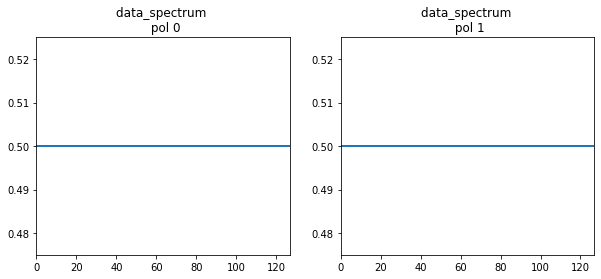

Data plots, + spectral line, width ~20% band:


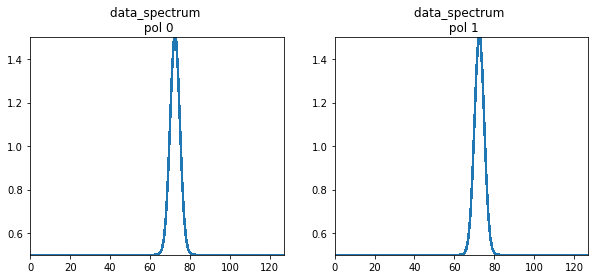

Data plots + polynomial cont:


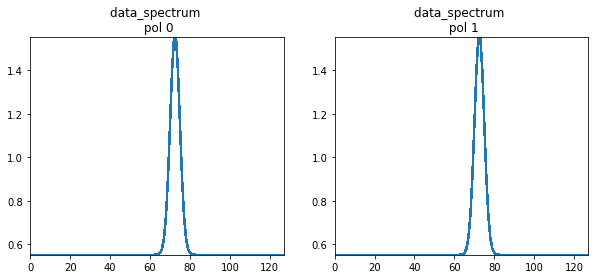

Data plots + Gaussian noise:


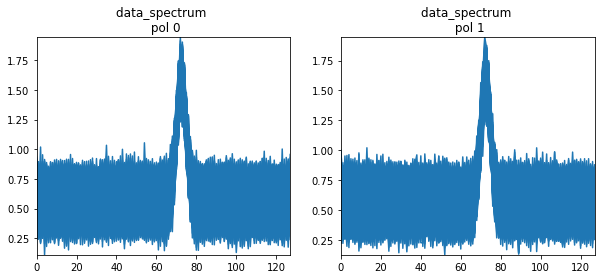

In [ ]:
os.system('rm -rf example_sim_alma_*.ms sim_alma_*.ms')

ms_name = 'example_sim_alma_noise_cont_poly_order_0.ms'
make_test_ms_alma_verif(ms_name, pol_coeffs=[0.05], verbose=True)


## More simple examples of test MSs

Plotting no-noise MS, with continuum as polynomial order 1


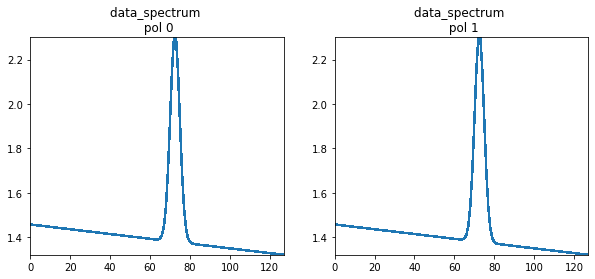

In [ ]:
# Still make a trivial order 0 without noise, for the most basic verif test
ms_name = 'example_sim_alma_nonoise_cont_poly_order_0.ms'
make_test_ms_alma_verif(ms_name, pol_coeffs=[0.5], noise_sigma=None, verbose=False)

ms_name = 'example_sim_alma_nonoise_cont_poly_order_1.ms'
make_test_ms_alma_verif(ms_name, pol_coeffs=[-0.1, 0.75], noise_sigma=None, verbose=False)
print('Plotting no-noise MS, with continuum as polynomial order 1')
plot_ms_data(ms_name, 'data_spectrum')

In [ ]:
!du -hsc *.ms

35M	example_sim_alma_noise_cont_poly_order_0.ms
35M	example_sim_alma_nonoise_cont_poly_order_0.ms
35M	example_sim_alma_nonoise_cont_poly_order_1.ms
105M	total


In [ ]:
from casatasks import listobs
res = listobs(vis=ms_name)
import pprint
pprint.pprint(res)
print(res)

{'BeginTime': 59500.80211451902,
 'EndTime': 59500.802207111614,
 'IntegrationTime': 8.0,
 'field_0': {'code': '',
             'direction': {'m0': {'unit': 'rad', 'value': -1.0494882958398402},
                           'm1': {'unit': 'rad', 'value': 0.7109380541842404},
                           'refer': 'J2000',
                           'type': 'direction'},
             'name': 'simulated_source'},
 'nfields': 1,
 'numrecords': 3612,
 'scan_1': {'0': {'BeginTime': 59500.80211451902,
                  'EndTime': 59500.802207111614,
                  'FieldId': 0,
                  'FieldName': 'simulated_source',
                  'IntegrationTime': 2.0,
                  'SpwIds': array([0]),
                  'StateId': 0,
                  'nRow': 3612,
                  'scanId': 1}},
 'timeref': 'UTC'}
{'BeginTime': 59500.80211451902, 'EndTime': 59500.802207111614, 'IntegrationTime': 8.0, 'field_0': {'code': '', 'direction': {'m0': {'unit': 'rad', 'value': -1.04948829583984

## MeasurementSets with continuum polynomials of order 0, 1, 2, 3, etc.

Plotting polynomial order 0:


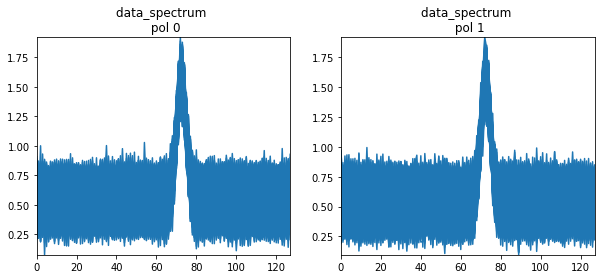

Plotting polynomial order 1:


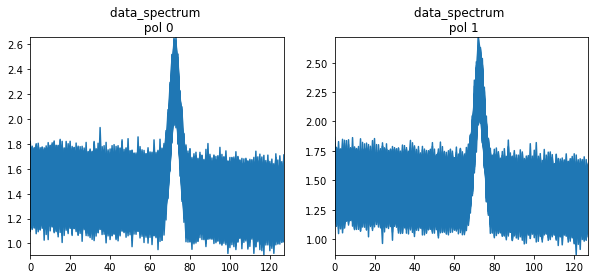

Plotting polynomial order 2:


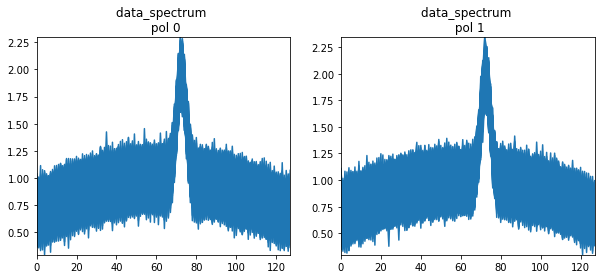

Plotting polynomial order 3:


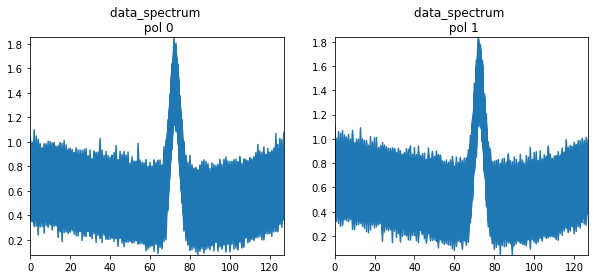

In [ ]:
# Giving coefficients as [0.1, 0.45] == 0.1x + 0.45
polynomials = {0: [0.025],
               1: [-0.1, 0.75],
               2: [-1, 1, 0.15],
               3: [1, -0.75, -0.25, 0.15]
               # Order 3 could also be of the style (not sure what type we'd 
               # want): 
               # [-1.35, 0, 1.5, 0.2]
}
for order, poly in polynomials.items():
   ms_name = f'sim_alma_cont_poly_order_{order}_nonoise.ms'
   os.system('rm -rf sim_*.cl')
   make_test_ms_alma_verif(ms_name, pol_coeffs=poly, noise_sigma=None, verbose=False)

   ms_name = f'sim_alma_cont_poly_order_{order}_noise.ms'
   os.system('rm -rf sim_*.cl')
   make_test_ms_alma_verif(ms_name, pol_coeffs=poly, verbose=False)
   print(f'Plotting polynomial order {order}:')
   plot_ms_data(ms_name, 'data_spectrum')

In [ ]:
# Check all MSs are there and their sizes
!du -hsc *.ms

35M	example_sim_alma_noise_cont_poly_order_0.ms
35M	example_sim_alma_nonoise_cont_poly_order_0.ms
35M	example_sim_alma_nonoise_cont_poly_order_1.ms
35M	sim_alma_cont_poly_order_0_noise.ms
35M	sim_alma_cont_poly_order_0_nonoise.ms
35M	sim_alma_cont_poly_order_1_noise.ms
35M	sim_alma_cont_poly_order_1_nonoise.ms
35M	sim_alma_cont_poly_order_2_noise.ms
35M	sim_alma_cont_poly_order_2_nonoise.ms
35M	sim_alma_cont_poly_order_3_noise.ms
35M	sim_alma_cont_poly_order_3_nonoise.ms
384M	total


## Noise level in the line free channels before and after continuum subtraction

When applying continuum subtraction, the output RMS increases with respect to the input RMS by a factor of 

$\mathrm{sqrt}(1+1/N_c)),$

where $N_c$ is the number of channels for which the continuum has been fitted. In the simple MeasurementSet examples above, where fitspec='0:0\~59;86\~127', $N_c = 102$ (from the 128 channels, there are 60 (left) + 42 (right) line free channels and 26 line channels.

The output residual continuum flux deviates from 0 following a standard deviation of 

$N_l s (1 + N_l / N_c)$, 

where $N_l$ is the number of line channels (26 in the simple simulations above) and $s$ is the sigma of the added artificial Gaussian noise.

### Output RMS

Since a fit can never be noise free the output will always have more noise, although for a good fit this extra noise would probably be close to negligible when the number of channels to fit is sufficiently large.

In the case in which the simulation is a flat continuum (polynomial of order 0) with known artificial Gaussian noise of sigma $s$, fitting a 0-order polynomial is numerically equivalent to compute the average across all the $N_c$ channels ($x_c$). The [standard error of that average](https://en.wikipedia.org/wiki/Standard_error#Standard_error_of_the_mean) is then $s/\sqrt{N_c}$ and the variance $s^2/N_c$. For a given visibility value in a channel ($x_i$), the value with continuum subtracted ($x_i - x_c$) has a variance of

$var(x_i) + var(x_{mean}) = s^2 + s^2/N_c = s^2 (1+1/N_c)$.

In other words, the variance of the output has been increased by a factor ($1+1/N_c)$ (or the RMS by a factor of $\sqrt{1+1/N_c}$). For the simulations above, where $N_c = 102$ line-free channels than means a factor $~1.005$. Note that this factor depends only on the number of line-free channels and is independent of the absolute values of the visibilities or the added noise.

### Output residual continuum flux

Assuming a simulated line profile $P_i$ with and additional continuum with a Gaussian distribution of mean $C$ and sigma $s$, each channel in the input spectrum is a statistical variable with a mean of $P_i + C$ and a standard deviation of $s$. Or in statistical notation:

$x_i \sim N(P_i + C, s),$ 

where $N(m,s)$ denotes the normal distribution with mean $m$ and sigma $s$.

The integrated flux ($F$) computed on the output spectrum is the sum over $N_l$ channels and is also a statistical variable that is the sum of several $x_i$ minus the estimated continuum $x_c$ that is itself a statistical variable:

$x_c \sim N(C, \sqrt{(s^2/N_c})$

$F \sim N(\sum P_i + (N_l C -N_l C), \sqrt{N_l s^2 + N_l s^2 / N_c} ),$

where $\sum P_i$ is the summation of the profile over the $N_l$ channels of the line.


The integrated flux minus the theoretical flux ($\sum P_i$) is also a statistical variable:

$F  - F_{theor} \sim N(0, \sqrt{N_l s^2 + N_l s^2 / N_c} ).$

Or in other words: the measured flux in the output spectrum minus the theoretical flux follows a normal distribution that will have a mean of 0 and a standard deviation of $\sqrt{N_l s^2 + N_l s^2 / N_c}$, or a variance of $N_l s (1 + N_l / N_c)$.

The interesting point is that, for this model, the residual continuum flux is independent of the line flux, and it will deviate from 0 following a standard deviation of $N_l s (1 + N_l / N_c)$. 

Note that the analysis would be different if one assumes different models in which the flux of the line contributes to the noise, like a Poisson distribution. In this model it is assumed that the noise is constant and independent of the visibility value.

# Continuum subtraction with uvcontsub2021

Several example commands to illustrate how uvcontsub2021 is applied to the simulated MSs.

## Using MeasurementSets for task verification test

In [ ]:
# Copy files to drive if needed to work with them outside of colab
copy_files = False
if 'google.colab' in str(get_ipython()) and copy_files:
  from google.colab import drive
  #drive.mount('/content/drive')
  !cp -r sim_*.ms /content/drive/MyDrive/sim_ms

{'description': 'summary of data fitting results in uv-continuum subtraction', 'goodness_of_fit': {'field': {'0': {'scan': {'1': {'spw': {'0': {'polarization': {'0': {'chi_squared': {'average': {'imag': 1.0526342391967773, 'real': 0.9639652371406555}, 'max': {'imag': 1.1145819425582886, 'real': 1.0763975381851196}, 'min': {'imag': 1.081458568572998, 'real': 0.7475039958953857}}, 'count': 4}, '1': {'chi_squared': {'average': {'imag': 1.047758936882019, 'real': 1.035971760749817}, 'max': {'imag': 1.0653717517852783, 'real': 1.148736834526062}, 'min': {'imag': 0.9923614263534546, 'real': 0.9539858102798462}}, 'count': 4}}}}}}}}}}
uv-cont result, polynomial order 0


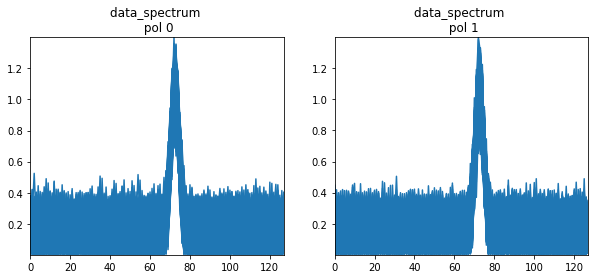

uv-cont result (no noise), polynomial order 1


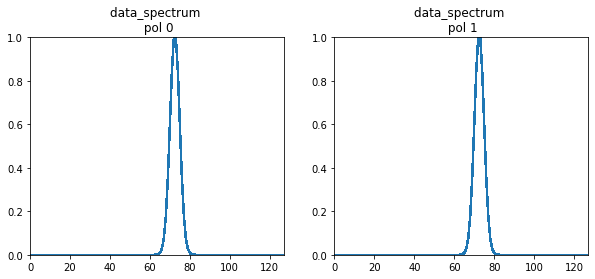

uv-cont result, polynomial order 1


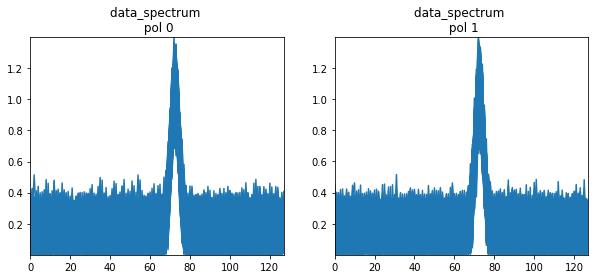

uv-cont result, polynomial order 2


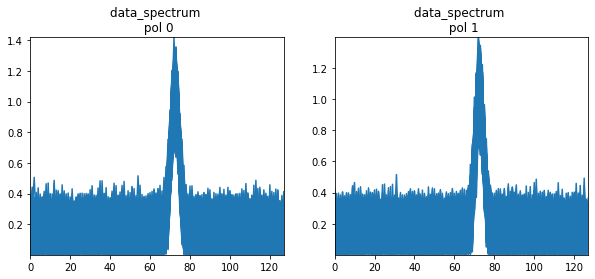

uv-cont result, polynomial order 3


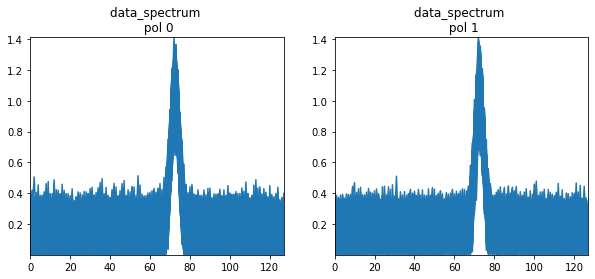

In [ ]:
try:
  from casatasks import uvcontsub2021
  fitspec='0:0~59;86~127'
  ms_uvcont = 'uvcont_noise_sub_0.ms'
  res = uvcontsub2021(vis='sim_alma_cont_poly_order_0_noise.ms', outputvis=ms_uvcont, 
                fitorder=0, fitspec=fitspec)
  print(res)
  print('uv-cont result, polynomial order 0')
  plot_ms_data(ms_uvcont, 'data_spectrum')

  ms_uvcont = 'uvcont_nonoise_sub_1.ms'
  res = uvcontsub2021(vis='sim_alma_cont_poly_order_1_nonoise.ms', outputvis=ms_uvcont, 
                      fitorder=1, fitspec=fitspec)
  print('uv-cont result (no noise), polynomial order 1')
  plot_ms_data(ms_uvcont, 'data_spectrum')

  ms_uvcont = 'uvcont_noise_sub_1.ms'
  res = uvcontsub2021(vis='sim_alma_cont_poly_order_1_noise.ms', outputvis=ms_uvcont, 
                      fitorder=1, fitspec=fitspec)
  print('uv-cont result, polynomial order 1')
  plot_ms_data(ms_uvcont, 'data_spectrum')

  ms_uvcont = 'uvcont_noise_sub_2.ms'
  res = uvcontsub2021(vis='sim_alma_cont_poly_order_2_noise.ms', outputvis=ms_uvcont, 
                      fitorder=2, fitspec=fitspec)
  print('uv-cont result, polynomial order 2')
  plot_ms_data(ms_uvcont, 'data_spectrum')

  ms_uvcont = 'uvcont_noise_sub_3.ms'
  res = uvcontsub2021(vis='sim_alma_cont_poly_order_3_noise.ms', outputvis=ms_uvcont, 
                      fitorder=3, fitspec=fitspec)
  print('uv-cont result, polynomial order 3')
  plot_ms_data(ms_uvcont, 'data_spectrum')

except ImportError as exc:
  print('Import error, most likely related to casatasks/tools not yet including '
        f'new uvcontsub: {exc}')

# Produce simulated MeasurementSets - for further testing and characterization

As opposed to the MSs produced for the task verification test, in the following functions we produce MSs without adding polynomials to the real and imaginary part of the visibilities. These MSs can be used to test the behavior of the task with sources 

In [ ]:
def make_test_ms_alma_further(ms_name, noise_sigma='0.5Jy', verbose=True):
  """
  Adds a point source, a spectral line, noise

  Args:
      noise_sigma: sigma for the Gaussian noise, set to None for no noise
      verbose: print and plot what is being done
  """
  ant_config = 'alma.cycle8.8.cfg'
  spw_params = {'name': "Simulated_Band",
                'freq': '150GHz',
                'nchan': 128}

  make_ms_frame(ms_name, ant_config=ant_config, spw_params=spw_params)

  add_point_source_component(ms_name, freq='125GHz', flux=0.5, 
                             spectrumtype='spectral index', index=-1.1)

  if verbose:
    print('Data plots. Only point source:')
    plot_ms_data(ms_name, 'data_spectrum')

  add_spectral_line(ms_name, chan_range=[60,86])
  if verbose:
    print('Data plots, + spectral line, width ~20% band:')
    plot_ms_data(ms_name, 'data_spectrum')

  if noise_sigma:
    add_ms_gaussian_noise(ms_name, noise_sigma)
    if verbose:
      print('Data plots + Gaussian noise:')
      plot_ms_data(ms_name, 'data_spectrum')

## Simple MSs

Plotting no-noise MS, with spectral index source


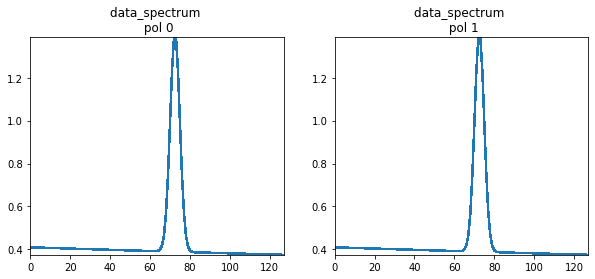

Plotting no-noise MS, with spectral index source


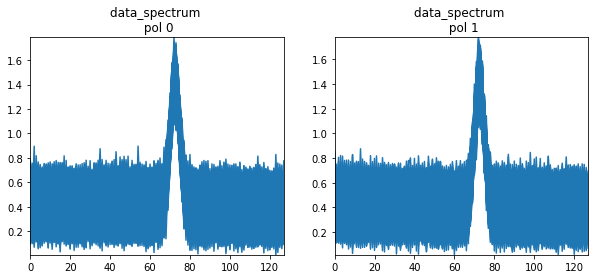

In [ ]:
ms_name = 'sim_alma_source_phase_center_nonoise.ms'
make_test_ms_alma_further(ms_name, noise_sigma=None, verbose=False)
print('Plotting no-noise MS, with spectral index source')
plot_ms_data(ms_name, 'data_spectrum')

ms_name = 'sim_alma_source_phase_center_noise.ms'
make_test_ms_alma_further(ms_name, noise_sigma='0.1Jy', verbose=False)
print('Plotting no-noise MS, with spectral index source')
plot_ms_data(ms_name, 'data_spectrum')